In [1]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# TensorFlow Similarity Redis Indexing

<a target="_blank" href="https://colab.research.google.com/github/tensorflow/similarity/blob/development/examples/indexing_colab.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>

[TensorFlow Similarity](https://github.com/tensorflow/similarity) is a python package focused on making similarity learning quick and easy. 

### Notebook goal

This notebook walks you through how to use different Search and Store types for indexing embeddings for nearest neighbor lookups, both for exact lookup and approximate lookups.
The Indexer uses two components to handle the indexing:

1.   **Search**: The component that given an embedding looks up k-nearest-neighbors of it
2.   **Store**: Stores and retrievs the metadata associated with a given embedding


The package currently supports the following NN algorithms (Search component):

*   **LinearSearch**
*   **NMSLib**
*   **Faiss**

Ans supports the following Stores:

*   **MemoryStore**: For small datasets that fit in the memory
*   **CachedStore**: For medium size datasets that would fit in the memory and disk of the machine
*   **RedisStore**: For larger datasets that would require a server to store and retrieve the metadata

In [2]:
import gc
import os

import numpy as np
from matplotlib import pyplot as plt
from tabulate import tabulate

# INFO messages are not printed.
# This must be run before loading other modules.
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"

In [3]:
import tensorflow as tf

In [4]:
# install TF similarity if needed
try:
    import tensorflow_similarity as tfsim  # main package
except ModuleNotFoundError:
    !pip install tensorflow_similarity
    import tensorflow_similarity as tfsim
from tensorflow_similarity.stores import CachedStore, RedisStore
from tensorflow_similarity.search import LinearSearch, FaissSearch
from tensorflow_similarity.losses import MultiSimilarityLoss
import tensorflow_similarity.visualization as tfsim_visualization

In [5]:
tfsim.utils.tf_cap_memory()

In [6]:
# Clear out any old model state.
gc.collect()
tf.keras.backend.clear_session()

In [7]:
print("TensorFlow:", tf.__version__)
print("TensorFlow Similarity", tfsim.__version__)

TensorFlow: 2.12.0
TensorFlow Similarity 0.18.0.dev8


## Install and test Redis connection

In [8]:
try:
    import redis
except ModuleNotFoundError:
    !pip install redis
    import redis
!if [ $(apt list redis-server 2>/dev/null | grep -c "redis-server") -eq 0 ]; then apt install redis-server; fi

In [9]:
#run redis in the background
!redis-server --daemonize yes

In [10]:
#test redis running
client = redis.Redis(host = 'localhost', port=6379)

client.ping()

True

## Data preparation

We are going to load the MNIST dataset and restrict our training data to **only N of the 10 classes** (6 by default) to showcase how the model is able to find similar examples from classes unseen during training. The model's ability to generalize the matching to unseen classes, without retraining, is one of the main reason you would want to use metric learning.


**WARNING**: Tensorflow similarity expects `y_train` to be an IntTensor containing the class ids for each example instead of the standard categorical encoding traditionally used for multi-class classification.

In [11]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

For a similarity model to learn efficiently, each batch must contains at least 2 examples of each class.

To make this easy, tf_similarity offers `Samplers()` that enable you to set both the number of classes and the minimum number of examples of each class per batch. Here we are creating a `TFDataSampler()` which allows you to sample from a `tf.data.Dataset`  and provides multiple examples per class.

TensorFlow Similarity provides various samplers to accomodate different requirements, including a `MultiShotMemorySampler()` for simple, single headed in-memory datsets, `SingleShotMemorySampler()` for single-shot learning, a `TFDatasetMultiShotMemorySampler()` that integrate directly with the TensorFlow datasets catalogue, and a `TFRecordDatasetSampler()` that allows you to sample from very large datasets stored on disk as TFRecords shards.

In [12]:
CLASSES = [2, 3, 1, 7, 9, 6, 8, 5, 0, 4]
NUM_CLASSES = 6  # @param {type: "slider", min: 1, max: 10}
CLASSES_PER_BATCH = NUM_CLASSES
EXAMPLES_PER_CLASS = 10  # @param {type:"integer"}
STEPS_PER_EPOCH = 1000  # @param {type:"integer"}

sampler = tfsim.samplers.TFDataSampler(
    ds=tf.data.Dataset.from_tensor_slices((x_train, y_train)),
    classes_per_batch=CLASSES_PER_BATCH,
    examples_per_class_per_batch=EXAMPLES_PER_CLASS,
    class_list=CLASSES[:NUM_CLASSES],  # Only use the first 6 classes for training.
)

## Model definition

`SimilarityModel()` models extend `tensorflow.keras.model.Model` with additional features and functionality that allow you to index and search for similar looking examples.

As visible in the model definition below, similarity models output a 64 dimensional float embedding using the `MetricEmbedding()` layers. This layer is a Dense layer with L2 normalization. Thanks to the loss, the model learns to minimize the distance between similar examples and maximize the distance between dissimilar examples. As a result, the distance between examples in the embedding space is meaningful; the smaller the distance the more similar the examples are. 

Being able to use a distance as a meaningful proxy for how similar two examples are, is what enables the fast ANN (aproximate nearest neighbor) search. Using a sub-linear ANN search instead of a standard quadratic NN search is what allows deep similarity search to scale to millions of items. The built in memory index used in this notebook scales to a million indexed examples very easily... if you have enough RAM :)

In [13]:
def get_model():
    inputs = tf.keras.layers.Input(shape=(28, 28, 1))
    x = tf.keras.layers.Rescaling(1.0 / 255.0)(inputs)
    x = tf.keras.layers.Conv2D(32, 3, activation="relu")(x)
    x = tf.keras.layers.Conv2D(32, 3, activation="relu")(x)
    x = tf.keras.layers.MaxPool2D()(x)
    x = tf.keras.layers.Conv2D(64, 3, activation="relu")(x)
    x = tf.keras.layers.Conv2D(64, 3, activation="relu")(x)
    x = tf.keras.layers.Flatten()(x)
    # smaller embeddings will have faster lookup times while a larger embedding will improve the accuracy up to a point.
    outputs = tfsim.layers.MetricEmbedding(64)(x)
    return tfsim.models.SimilarityModel(inputs, outputs)


model = get_model()
model.summary()

Model: "similarity_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 rescaling (Rescaling)       (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 64)        18496     
                                                  

# Use FaissSearch and CachedStore

Now that we have created the model, we need to load the Store and Search components and pass them to compile to be integrated into the model for indexing.

## Load Store and Search components and compile the model

In [14]:
distance = "cosine"  # @param ["cosine", "L2", "L1"]{allow-input: false}
loss = MultiSimilarityLoss(distance=distance)
store = CachedStore()
search = FaissSearch(distance, 64)
LR = 0.000005  # @param {type:"number"}
model.compile(optimizer=tf.keras.optimizers.Adam(LR), loss=loss, kv_store=store, search=search)

Distance metric automatically set to cosine use the distance arg to override.


## Training

Epoch 1/2
1000/1000 [==============================] - 6s 4ms/step - loss: 0.8200 - val_loss: 0.4353
Epoch 2/2
1000/1000 [==============================] - 4s 4ms/step - loss: 0.5215 - val_loss: 0.3946


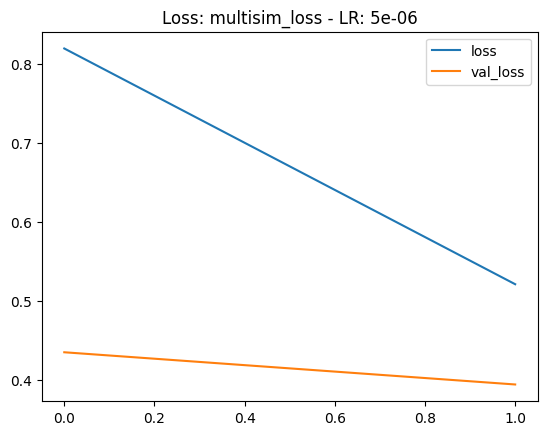

In [15]:
EPOCHS = 2  # @param {type:"integer"}
history = model.fit(sampler, steps_per_epoch=STEPS_PER_EPOCH, epochs=EPOCHS, validation_data=(x_test, y_test))
# expect loss: 0.14 / val_loss: 0.33
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["loss", "val_loss"])
plt.title(f"Loss: {loss.name} - LR: {LR}")
plt.show()

## Build the indexer

In [16]:
x_index, y_index = tfsim.samplers.select_examples(x_train, y_train, CLASSES, 2048)
model.reset_index()
model.index(x_index, y_index, data=x_index)
print()
model.index_summary()

filtering examples:   0%|          | 0/60000 [00:00<?, ?it/s]

selecting classes:   0%|          | 0/10 [00:00<?, ?it/s]

gather examples:   0%|          | 0/20480 [00:00<?, ?it/s]

[Indexing 20480 points]
|-Computing embeddings
640/640 [==============================] - 1s 994us/step
|-Storing data points in key value store
building Faiss index


WARNING clustering 20480 points to 1024 centroids: please provide at least 39936 training points



[Info]
------------------  -----------
distance            cosine
key value store     CachedStore
search algorithm    FaissSearch
evaluator           memory
index size          20480
calibrated          False
calibration_metric  f1
embedding_output
------------------  -----------



[Performance]
-----------  -
num lookups  0
min          0
max          0
avg          0
median       0
stddev       0
-----------  -


## Lookup and visualize 5 nearest neighbors for each class

filtering examples:   0%|          | 0/10000 [00:00<?, ?it/s]

selecting classes:   0%|          | 0/10 [00:00<?, ?it/s]

gather examples:   0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 59ms/step

Performing NN search



Building NN list:   0%|          | 0/10 [00:00<?, ?it/s]

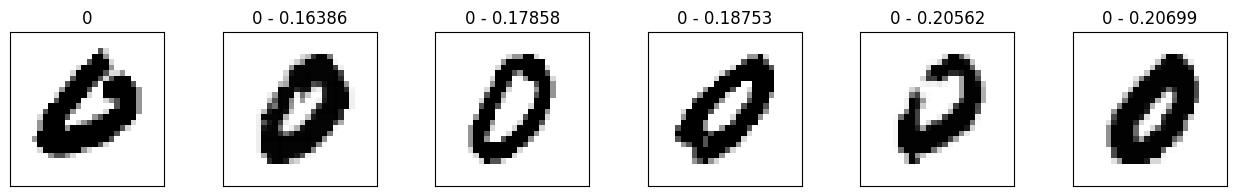

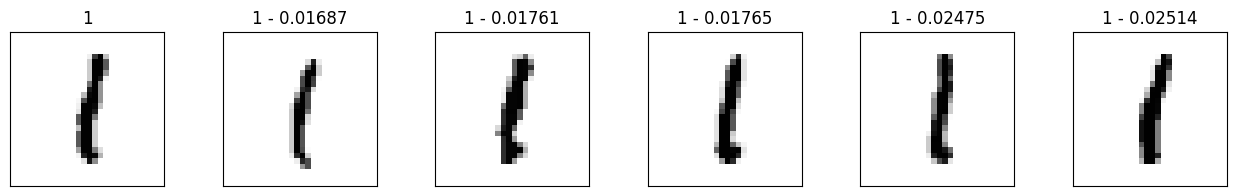

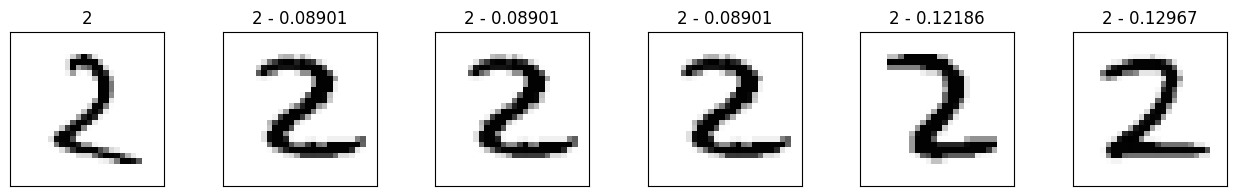

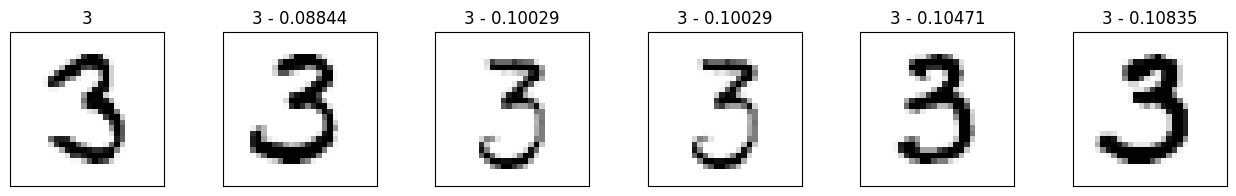

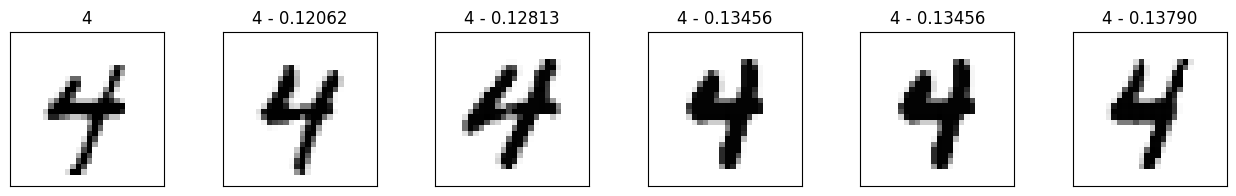

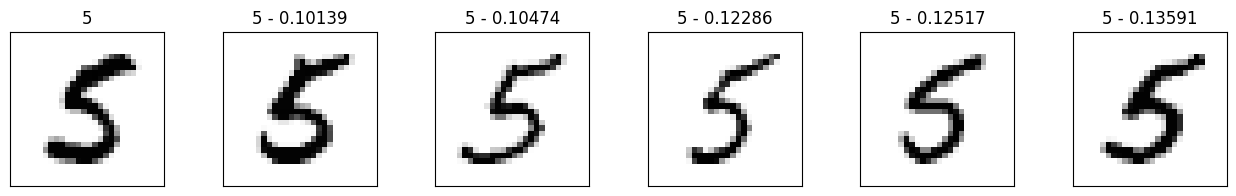

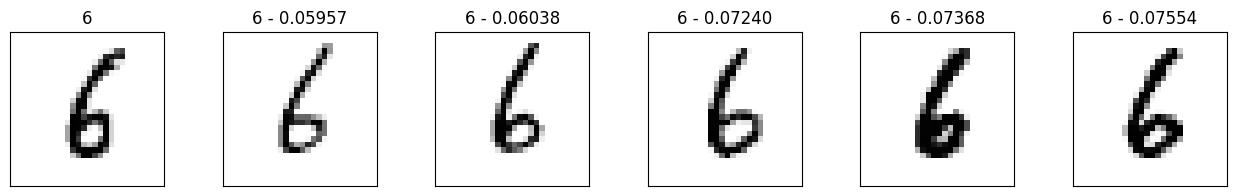

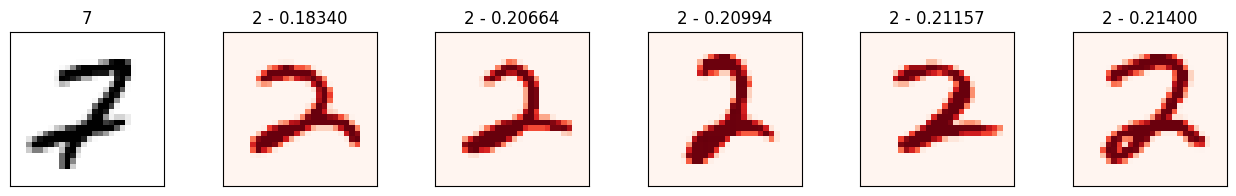

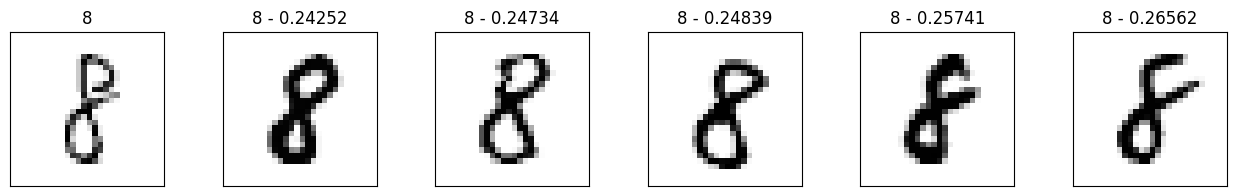

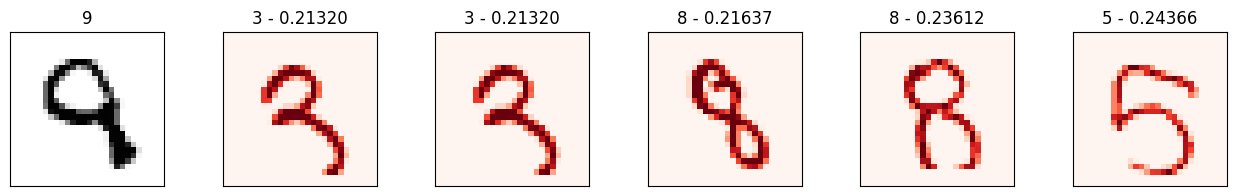

In [17]:
#@title NN lookup results
# re-run to test on other examples
num_neighbors = 5

# select
x_display, y_display = tfsim.samplers.select_examples(x_test, y_test, CLASSES, 1)

# lookup nearest neighbors in the index
nns = model.lookup(x_display, k=num_neighbors)

# display
for idx in np.argsort(y_display):
    tfsim_visualization.viz_neigbors_imgs(x_display[idx], y_display[idx], nns[idx], fig_size=(16, 2), cmap="Greys")

## Save model and indexer

In [18]:
#@title save the model and the index
save_path = "models/hello_world"  # @param {type:"string"}
model.save(save_path, save_index=True)

INFO:tensorflow:Assets written to: models/hello_world/assets


INFO:tensorflow:Assets written to: models/hello_world/assets


# Use LinearSearch and RedisStore

## Reload our previous model

In [19]:
reloaded_model = tf.keras.models.load_model(
    save_path,
    custom_objects={"SimilarityModel": tfsim.models.SimilarityModel},
)
# reload the index
reloaded_model.load_index(save_path)

Distance metric automatically set to cosine use the distance arg to override.
Loading index data
Loading search index


## Replace our Search and Store objects

Here we replace the FaissSearch and CachedStore with LinearSearch and RedisStore objects. 

In [20]:
model.create_index(
    distance="cosine",
    search=LinearSearch('cosine', 64),
    kv_store=RedisStore(),
)

## Build the indexer

In [21]:
model.reset_index()
model.index(x_index, y_index, data=x_index)
print()
model.index_summary()

[Indexing 20480 points]
|-Computing embeddings
640/640 [==============================] - 1s 1ms/step
|-Storing data points in key value store

[Info]
------------------  ------------
distance            cosine
key value store     RedisStore
search algorithm    LinearSearch
evaluator           memory
index size          20480
calibrated          False
calibration_metric  f1
embedding_output
------------------  ------------



[Performance]
-----------  -
num lookups  0
min          0
max          0
avg          0
median       0
stddev       0
-----------  -


## Lookup and visualize 5 nearest neighbors for each class

filtering examples:   0%|          | 0/10000 [00:00<?, ?it/s]

selecting classes:   0%|          | 0/10 [00:00<?, ?it/s]

gather examples:   0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 11ms/step

Performing NN search



Building NN list:   0%|          | 0/10 [00:00<?, ?it/s]

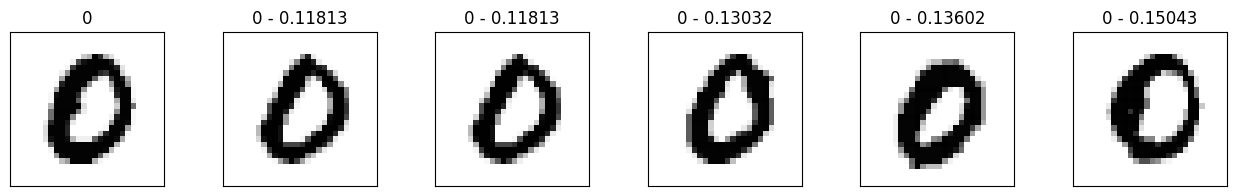

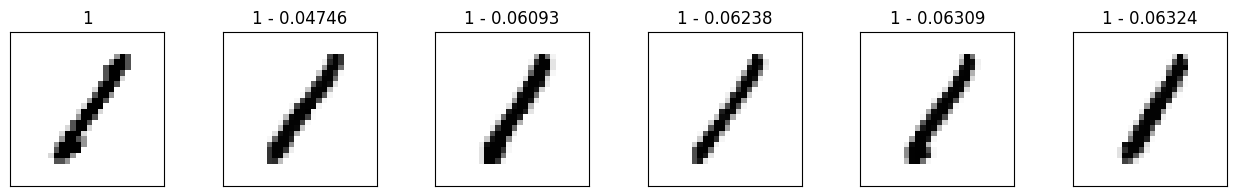

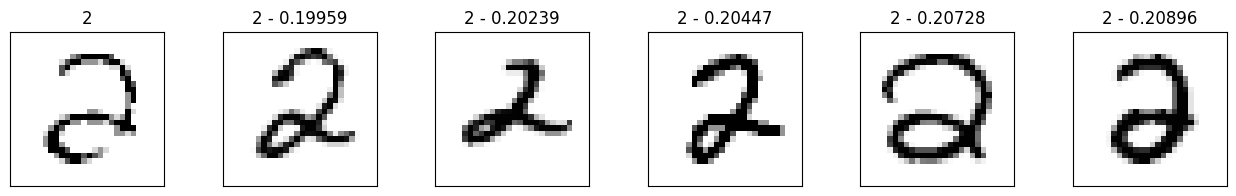

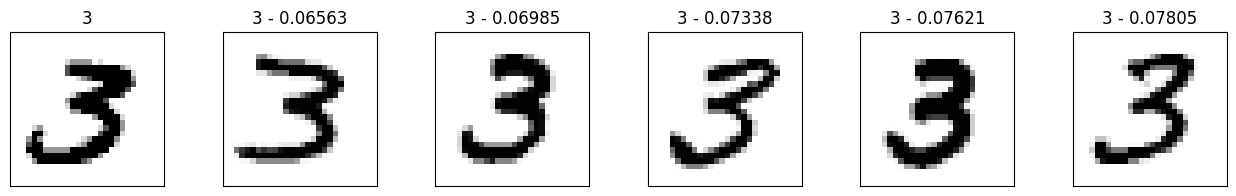

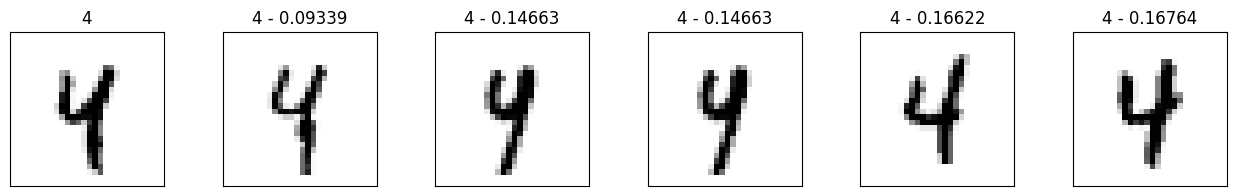

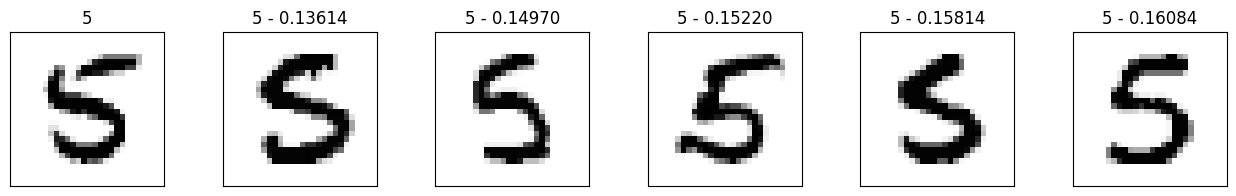

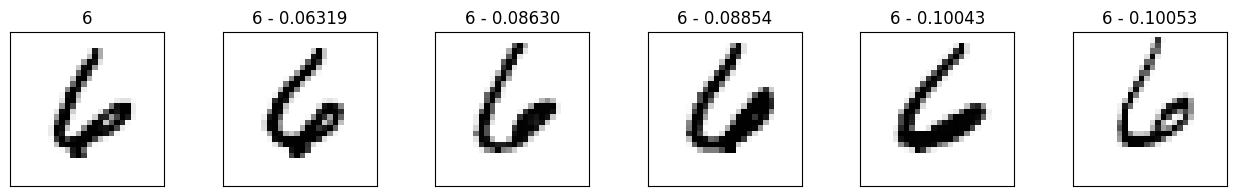

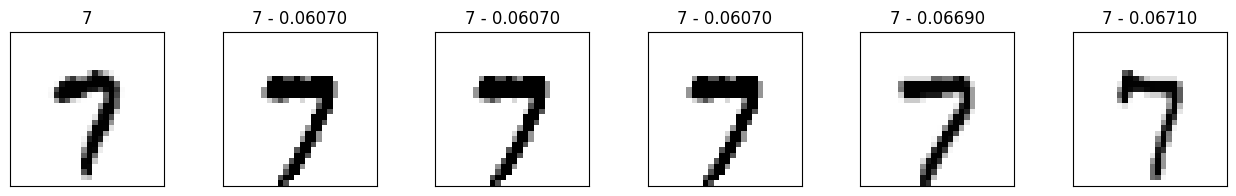

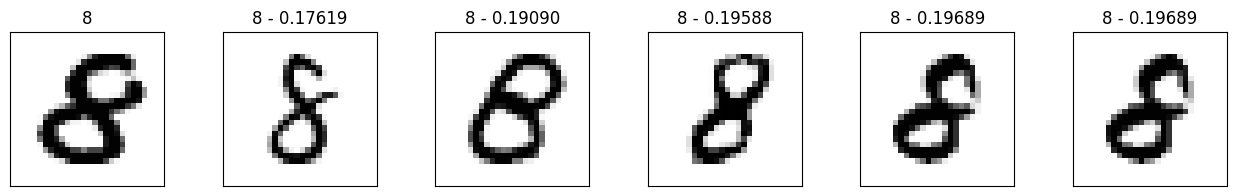

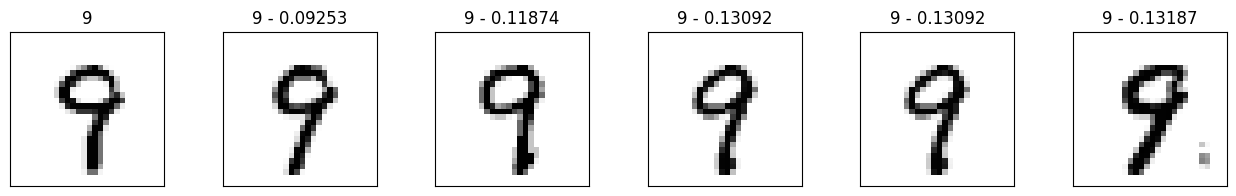

In [22]:
#@title NN lookup results
# re-run to test on other examples
num_neighbors = 5

# select
x_display, y_display = tfsim.samplers.select_examples(x_test, y_test, CLASSES, 1)

# lookup nearest neighbors in the index
nns = model.lookup(x_display, k=num_neighbors)

# display
for idx in np.argsort(y_display):
    tfsim.visualization.viz_neigbors_imgs(x_display[idx], y_display[idx], nns[idx], fig_size=(16, 2), cmap="Greys")